In [ ]:
!pip3 install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
df = pd.read_csv(os.path.join('/Users/admin/Desktop/AI:ML/Comment_Toxicity/Comments/train.csv'))

In [ ]:
df.head()

In [ ]:
!pip3 list

In [6]:
from tensorflow.keras.layers import TextVectorization

In [7]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [8]:
MAX_FEATURES = 200000 # number of words in the vocab

In [9]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [10]:
vectorizer.adapt(X.values)

In [11]:
vectorized_text = vectorizer(X.values)

In [12]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [13]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [15]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [16]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [19]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5


6981/6981 [==============================] - 4126s 591ms/step - loss: 0.0564 - val_loss: 0.0460
Epoch 2/5
6981/6981 [==============================] - 3886s 557ms/step - loss: 0.0461 - val_loss: 0.0413
Epoch 3/5
6981/6981 [==============================] - 3953s 566ms/step - loss: 0.0404 - val_loss: 0.0351
Epoch 4/5
6981/6981 [==============================] - 3944s 565ms/step - loss: 0.0358 - val_loss: 0.0329
Epoch 5/5
6981/6981 [==============================] - 4425s 634ms/step - loss: 0.0320 - val_loss: 0.0291


In [20]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

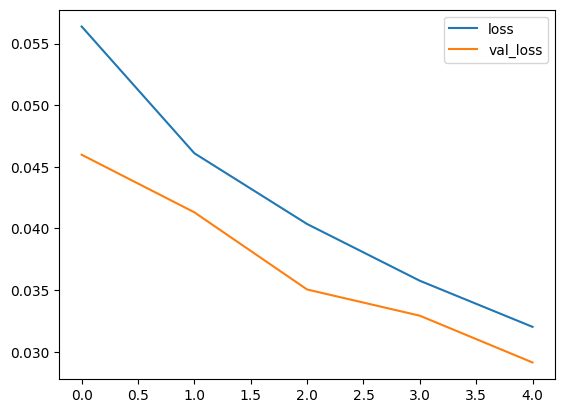

In [21]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [24]:
input_text = vectorizer(['You freaking suck! I am going to hit you.'])


In [25]:
res = model.predict(input_text)

1/1 [==============================] - 1s 713ms/step


In [26]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [27]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [28]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 102ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [29]:
res.shape

(1, 6)

In [30]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [31]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [32]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 106ms/step


In [33]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8958868980407715, Recall:0.7800783514976501, Accuracy:0.4974924921989441


In [34]:
!pip3 install gradio jinja2

Defaulting to user installation because normal site-packages is not writeable
  Using cached Jinja2-3.1.3-py3-none-any.whl.metadata (3.3 kB)
  Preparing metadata (setup.py) ... done
  Using cached httpx-0.27.0-py3-none-any.whl.metadata (7.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 528.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 629.4 kB/s eta 0:00:00a 0:00:01
  Using cached jsonschema-4.21.1-py3-none-any.whl.metadata (7.8 kB)
  Using cached anyio-4.3.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached httpcore-1.0.4-py3-none-any.whl.metadata (20 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
  Using cached jsonschema_specifications-2023.12.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached rpds_py-0.18.0-cp39-cp39-macosx_10_12_x86_64.whl.metadata (4.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 694.4 kB/s eta 0:00:0000:0100:0

In [35]:
import tensorflow as tf
import gradio as gr

/Users/admin/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
model.save('toxicity.h5')

/Users/admin/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
model = tf.keras.models.load_model('toxicity.h5')

In [39]:
input_str = vectorizer('hey i freaken hate you!')
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 867ms/step


In [40]:
res

array([[0.86443734, 0.00120974, 0.07826721, 0.00326295, 0.2993432 ,
        0.01386209]], dtype=float32)

In [41]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [45]:
import gradio as gr

interface = gr.Interface(fn=score_comment, 
                         inputs="text",
                         outputs="text")

interface.launch()


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 91ms/step


In [46]:
interface.launch(share=True)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Running on public URL: https://5f137fc6532a9793f1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 64ms/step
